In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
try:
    import xgboost as xgb
    from xgboost import plot_importance
except ImportError:
    %pip install -q xgboost
try:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
    from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.mixture import GaussianMixture  # Using GMM for clustering
    from sklearn.manifold import LocallyLinearEmbedding  # For dimensionality reduction
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    from sklearn.dummy import DummyRegressor
except ImportError:
    %pip install sklearn
try:
    from collections import Counter
except ImportError:
    %pip install collections

In [2]:
# first, re-create clusters. RF was run on top features predicting clusters
# from Courtney

# data import: ENV
# assumes this script saved one folder up of /data
pfa_data = pd.read_csv('./data/raw_data/PFAS_ENV.csv')

# Display the first few rows of each dataset for exploration
print("PFAs Data:")
print(pfa_data.head())

# Convert 'DATE' column to datetime format
pfa_data['DATE'] = pd.to_datetime(pfa_data['DATE'], format='%m/%d/%Y')

#CLUSTERING MODEL (GMM with 8 Clusters from AIC/BIC)

# Select numeric columns for clustering
numeric_columns = pfa_data.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
pfa_data_imputed = imputer.fit_transform(pfa_data[numeric_columns])

# Scale the data
scaler = StandardScaler()
pfa_scaled = scaler.fit_transform(pfa_data_imputed)

# Apply Gaussian Mixture Model with the optimal number of clusters (8 clusters)
gmm_final = GaussianMixture(n_components=8, random_state=42)
pfa_data['Cluster'] = gmm_final.fit_predict(pfa_scaled)

PFAs Data:
      NAWQA_ID       DATE  TIME 4_2 FTS-RMK  4_2 FTS-VA 6_2 FTS-RMK  \
0  MIAMSUS1-01  8/21/2019  1200           <         8.0           <   
1  MIAMSUS1-02   7/1/2019  1100           <         7.7           <   
2  MIAMSUS1-03   7/2/2019  1100           <         7.7           <   
3  MIAMSUS1-04   7/9/2019  1100           <         8.0           <   
4  MIAMSUS1-05  7/10/2019  1100           <         8.0           <   

   6_2 FTS-VA 8_2 FTS-RMK  8_2 FTS-VA N-EtFOSAA-RMK  ...  PFPeS-RMK PFPeS-VA  \
0         8.0           <         8.0             <  ...          <      4.0   
1         7.7           <         7.7             <  ...          <      3.8   
2         7.7           <         7.7             <  ...          <      3.8   
3         8.0           <         8.0             <  ...        NaN      7.8   
4         8.0           <         8.0             <  ...          <      4.0   

   PFPeA-RMK PFPeA-VA  PFTeDA-RMK PFTeDA-VA  PFTrDA-RMK PFTrDA-VA  PFUnA-RMK  \
0

In [3]:
print(np.sort(pfa_data.Cluster.unique()))

[0 1 2 3 4 5 6 7]


In [4]:
key_pfas = ['PFOS-VA', 'PFBA-VA', 'PFHxS-VA', 'PFOA-VA']

In [5]:
# X, y declarations

X = pfa_data[key_pfas]  # Using the top features as the predictors
y = pfa_data['Cluster']  # Cluster labels as the target

# Count instances of each class
class_counts = Counter(y)
print("Class distribution:", class_counts)

# DROP clusters 3, 5, 7 due to sparsity AND 0
valid_classes = [cls for cls, count in class_counts.items() if count >= 5]

# Filter out rows with invalid classes
mask = np.isin(y, valid_classes)
X, y = X[mask], y[mask]

Class distribution: Counter({1: 96, 2: 81, 6: 36, 4: 34, 0: 4, 7: 1, 5: 1, 3: 1})


In [6]:
Counter(y)

Counter({1: 96, 2: 81, 4: 34, 6: 36})

In [7]:
# stratify y for equal class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [8]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 67, 2: 56, 6: 25, 4: 24})
Counter({1: 29, 2: 25, 6: 11, 4: 10})


In [9]:
# Re-index the class labels to ensure they start from 0
# Create a mapping of old labels to new ones starting from 0
class_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train = np.array([class_mapping[label] for label in y_train])
y_test = np.array([class_mapping[label] for label in y_test])
y_train

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 3, 1, 2, 0,
       0, 1, 0, 1, 1, 0, 2, 3, 1, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 1,
       0, 2, 1, 1, 2, 1, 0, 3, 1, 0, 3, 1, 0, 1, 0, 3, 3, 2, 1, 3, 0, 0,
       1, 2, 1, 2, 0, 1, 0, 0, 1, 1, 0, 0, 3, 0, 1, 0, 3, 0, 0, 1, 0, 2,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 0,
       0, 2, 0, 1, 1, 0, 1, 2, 3, 0, 0, 3, 0, 2, 0, 2, 0, 0, 0, 1, 3, 3,
       1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 0, 2, 3, 2, 3, 0, 0, 2, 0, 3, 0,
       1, 0, 1, 1, 2, 0, 1, 0, 3, 3, 0, 2, 1, 1, 0, 2, 3, 3])

## Experiment 1: Predict cluster based off key_pfas levels
This was already done as a baseline using Random Forest. This experiment aims to improve upon this technique by using boosted regression trees. The logic is that the sequential learning nature of this approach could improve accuracy.

In [10]:
# init XBGClassifier
# optimization: softmax
# eval: min log loss

xgb_model = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.79      0.88      0.83        25
           2       0.50      0.50      0.50        10
           3       0.88      0.64      0.74        11

    accuracy                           0.79        75
   macro avg       0.76      0.72      0.73        75
weighted avg       0.79      0.79      0.78        75



In [12]:
# GRID SEARCH for hyperparameter tuning
xgb_clf = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss", use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5], # 7
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation, limited due to memory constraints
    verbose=2,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.8662028634805404


It appears that the optimal boosted tree setup includes:
- depth = 3 (max depth of a tree)
- learning_rate = 0.01 (step size, prevent overfitting)
- n_estimators = 200 
- gamma = 5 (min loss reduction for a split)
- subsample = 0.8 (fraction of samples for growing trees)
- colsample_bytree = 0.8 (fraction of features per tree)

Achieving 86.62% accuracy in train

Test Accuracy: 0.7733333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        29
           1       0.75      0.84      0.79        25
           2       0.50      0.70      0.58        10
           3       0.86      0.55      0.67        11

    accuracy                           0.77        75
   macro avg       0.76      0.73      0.73        75
weighted avg       0.80      0.77      0.78        75

Confusion Matrix:
 [[24  1  3  1]
 [ 1 21  3  0]
 [ 0  3  7  0]
 [ 1  3  1  6]]


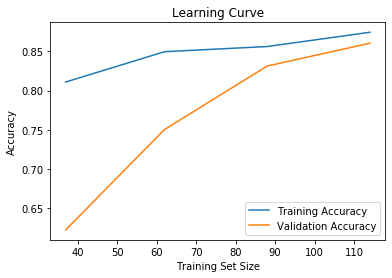

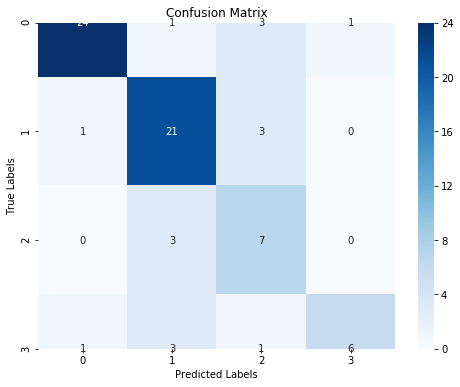

In [13]:
best_model = grid_search.best_estimator_
y_pred = grid_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train,
    scoring="accuracy", cv=3, n_jobs=-1
)

train_accuracy = train_scores.mean(axis=1)
val_accuracy = val_scores.mean(axis=1)

plt.plot(train_sizes, train_accuracy, label='Training Accuracy')
plt.plot(train_sizes, val_accuracy, label='Validation Accuracy')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Analysis
- Test and train learning curves appear to converge, indicating not much overfitting during training
- Train acc: 86%; test: 77%
- f-1 score also 0.77, indicating not much class imbalance
- pretty good precision/recall
- improvement upon random forest

## Experiment 2: Predict amounts of key_pfas based off env/pharma/geo data

This experiment aims to predict concentrations of key PFAS by regressing on the presence or amounts of external features, such as pharmaceutical compunds, geographical features, and other environmental features.


TODO:
- figure out best way to choose features for selection. Maybe running a broad linear regression and evaluating feature importance?
- once features whittled down, join data and extrac X (features) and y (target concentration)
- run train/test split on joined data
- run xgboost baseline + grid search
- plot/summarize results

In [14]:
pfa_data.head()

,NAWQA_ID,DATE,TIME,4_2 FTS-RMK,4_2 FTS-VA,6_2 FTS-RMK,6_2 FTS-VA,8_2 FTS-RMK,8_2 FTS-VA,N-EtFOSAA-RMK,...,PFPeS-VA,PFPeA-RMK,PFPeA-VA,PFTeDA-RMK,PFTeDA-VA,PFTrDA-RMK,PFTrDA-VA,PFUnA-RMK,PFUnA-VA,Cluster
0,MIAMSUS1-01,2019-08-21,1200,<,8.0,<,8.0,<,8.0,<,...,4.0,n,1.7,<,4.0,<,4.0,<,4.0,1
1,MIAMSUS1-02,2019-07-01,1100,<,7.7,<,7.7,<,7.7,<,...,3.8,<,3.8,<,3.8,<,3.8,<,3.8,2
2,MIAMSUS1-03,2019-07-02,1100,<,7.7,<,7.7,<,7.7,<,...,3.8,<,3.8,<,3.8,<,3.8,<,3.8,2
3,MIAMSUS1-04,2019-07-09,1100,<,8.0,<,8.0,<,8.0,<,...,7.8,<,4.0,<,4.0,<,4.0,<,4.0,4
4,MIAMSUS1-05,2019-07-10,1100,<,8.0,<,8.0,<,8.0,<,...,4.0,<,4.0,<,4.0,<,4.0,<,4.0,1


In [15]:
geo_data = pd.read_csv('./data/raw_data/PFAS_GEOSPATIAL.csv')
inorganics_data = pd.read_csv('./data/raw_data/PFAS_INORGANICS_AND_OTHER.csv')
pharma_data = pd.read_csv('./data/raw_data/PFAS_PHARMA.csv')
vocs_data = pd.read_csv('./data/raw_data/PFAS_VOCs.csv')

In [16]:
geo_env = pd.merge(pfa_data,geo_data,how='inner',on='NAWQA_ID')
geo_env.head()

,NAWQA_ID,DATE,TIME,4_2 FTS-RMK,4_2 FTS-VA,6_2 FTS-RMK,6_2 FTS-VA,8_2 FTS-RMK,8_2 FTS-VA,N-EtFOSAA-RMK,...,PETR,PLAS,TEXTILE,AIRNG,ARMNG,FIRE_ST,FRS,SUPER,OILREF,AIRP
0,MIAMSUS1-01,2019-08-21,1200,<,8.0,<,8.0,<,8.0,<,...,7047,6371,30633,85255,7275,5279,368,40875,120274,9140
1,MIAMSUS1-02,2019-07-01,1100,<,7.7,<,7.7,<,7.7,<,...,33141,6147,40594,25090,19790,4790,2557,36219,78304,6111
2,MIAMSUS1-03,2019-07-02,1100,<,7.7,<,7.7,<,7.7,<,...,8612,5631,19810,7261,17133,2804,2956,19110,97923,7070
3,MIAMSUS1-04,2019-07-09,1100,<,8.0,<,8.0,<,8.0,<,...,29071,5070,34443,14541,3948,4029,1139,37800,95976,2885
4,MIAMSUS1-05,2019-07-10,1100,<,8.0,<,8.0,<,8.0,<,...,45280,20471,31283,40500,35719,7036,4451,37756,62520,10199


In [17]:
pharm_geo_env = pd.merge(geo_env,pharma_data,how='inner',on='NAWQA_ID')
joined_data = pd.merge(pharm_geo_env,vocs_data,how='inner',on='NAWQA_ID')
joined_data.head()

,NAWQA_ID,DATE_x,TIME_x,4_2 FTS-RMK,4_2 FTS-VA,6_2 FTS-RMK,6_2 FTS-VA,8_2 FTS-RMK,8_2 FTS-VA,N-EtFOSAA-RMK,...,5MHEX-RMK,5MHEX-VA,BUTA-RMK,BUTA-VA,IACE-RMK,IACE-VA,NPENAL-RMK,NPENAL-VA,PACE-RMK,PACE-VA
0,MIAMSUS1-02,2019-07-01,1100,<,7.7,<,7.7,<,7.7,<,...,<,0.022,<,0.08,<,0.01,<,0.054,<,0.032
1,MIAMSUS1-03,2019-07-02,1100,<,7.7,<,7.7,<,7.7,<,...,<,0.022,<,0.08,<,0.01,<,0.054,<,0.032
2,MIAMSUS1-10,2019-07-23,1100,<,7.1,<,7.1,<,7.1,<,...,<,0.022,<,0.08,<,0.01,<,0.054,<,0.032
3,MIAMSUS1-14,2019-07-30,1200,<,6.9,<,6.9,<,6.9,<,...,<,0.022,<,0.08,<,0.01,<,0.054,<,0.032
4,MIAMSUS1-17,2019-08-05,1100,<,7.7,<,7.7,<,7.7,<,...,<,0.022,<,0.08,<,0.01,<,0.054,<,0.032


In [18]:
# clean joined data
# y: PFOS-VA for simplicity
# x: everything not that

X = joined_data.drop('PFOS-VA', axis=1)
y = joined_data['PFOS-VA']

# Select numeric columns for clustering
numeric_columns_X = X.select_dtypes(include=['float64', 'int64']).columns
feature_names = numeric_columns_X  

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X[numeric_columns_X])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled

array([[-0.36398632, -0.17955728, -0.06983722, ...,  0.        ,
         0.15195862,  0.25237723],
       [-0.36398632, -0.17955728, -0.06983722, ...,  0.        ,
         0.15195862,  0.25237723],
       [-0.36398632, -1.31826864, -0.6946309 , ...,  0.        ,
         0.15195862,  0.25237723],
       ...,
       [ 0.19780402, -0.74891296, -0.38223406, ...,  0.        ,
         0.15195862,  0.25237723],
       [-1.48756699,  0.3897984 ,  0.24255962, ...,  0.        ,
         0.15195862,  0.25237723],
       [-0.92577665,  0.3897984 ,  0.24255962, ...,  0.        ,
         0.15195862,  0.25237723]])

In [19]:
# PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-3.457872  , -1.62577948, -1.85647889, ...,  0.02607279,
        -1.63406956,  0.92775694],
       [-3.42934194, -1.83379982, -2.09645046, ...,  0.06228166,
        -1.4756363 ,  0.97623622],
       [-2.54818085, -1.76979078, -2.02184102, ...,  0.29206648,
         0.33225761, -0.54111805],
       ...,
       [ 9.81681067,  3.02203429, -4.5316171 , ...,  1.22688559,
        -0.04942866, -1.32735554],
       [ 6.28340261,  1.62925157,  2.03007673, ...,  1.44354777,
         8.12267937, -0.36664572],
       [ 3.39643416, -1.42519028, 14.72781773, ...,  3.27201646,
        -0.12130615, -1.60893027]])

In [20]:
selector = SelectKBest(score_func=mutual_info_regression, k=10)
X_selected = selector.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# init 
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
print(f"R^2 on test set: {model.score(X_test, y_test):.2f}")

R^2 on test set: -1.09


In [21]:
xgb_model = xgb.XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
feature_importances = xgb_model.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [2.07284186e-03 1.22567115e-04 1.07198521e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.17420603e-03 1.23073638e-03
 8.81802916e-05 0.00000000e+00 0.00000000e+00 3.00123543e-01
 7.62111973e-03 1.99943334e-01 1.47139898e-03 0.00000000e+00
 2.05781627e-02 0.00000000e+00 3.49752198e-04 2.90815160e-02
 5.51023521e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.71857562e-06 1.16826377e-04 1.14169170e-05 1.39648269e-04
 1.97101268e-03 1.68711275e-01 1.80965550e-02 2.01969477e-03
 1.65310726e-02 5.79091138e-04 1.74751133e-02 1.91463521e-04
 3.27363659e-06 7.66715617e-04 8.33797239e-05 5.47803284e-05
 9.68634430e-03 3.18033344e-05 4.83601907e-05 7.30304164e-04
 1.09544417e-05 9.94296101e-07 1.75639449e-04 7.31148710e-03
 2.64490791e-06 9.48991728e-05 2.34367355e-04 1.11717229e-04
 1.39146316e-04 2.84745274e-05 5.12514729e-03 8.79255030e-03
 1.28196425e-05 0.00000000e+00 2.13479939e-06 0.00000000e+00
 0.00000000e+00 2.96683027e-07 0.00000000e+00 0.00000000e+00
 0.

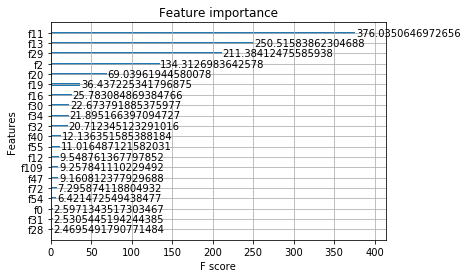

In [22]:
plot_importance(xgb_model, importance_type='gain', max_num_features=20)
plt.show()

In [23]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feature_importance_df.head(20))

       Feature  Importance
0     PFHpS-VA    0.300124
1     PFHxS-VA    0.199943
2   FIRE_TRAIN    0.168711
3   6_2 FTS-VA    0.107199
4     PFPeA-VA    0.055102
5     PFPeS-VA    0.029082
6      PFNA-VA    0.020578
7         CEMT    0.018097
8        ELEC     0.017475
9      CLEAN      0.016531
10      MACH      0.009686
11        AIRP    0.008793
12    PFHpA-VA    0.007621
13     MEPR-VA    0.007389
14      PLAS      0.007311
15     CARB-VA    0.005823
16      OILREF    0.005125
17      TIME_x    0.002073
18       CHEM     0.002020
19        WSWT    0.001971


In [24]:
threshold = 0.01  # Adjust based on your data
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']
X_selected = X[selected_features]

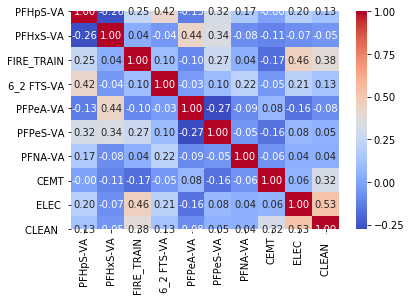

In [25]:
correlation_matrix = X[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [26]:
# ELEC and CLEAN or PFHxS-VA and PFPeA-VA ; drop one from each pair with lower feature importance
feature_importance_df.head(10) # drop CLEAN, PFPeA-VA

,Feature,Importance
0,PFHpS-VA,0.300124
1,PFHxS-VA,0.199943
2,FIRE_TRAIN,0.168711
3,6_2 FTS-VA,0.107199
4,PFPeA-VA,0.055102
5,PFPeS-VA,0.029082
6,PFNA-VA,0.020578
7,CEMT,0.018097
8,ELEC,0.017475
9,CLEAN,0.016531


In [27]:
# Select top 10 and drop two correlated ones --> changed to top 5 after seeing it improves results
selected_features = feature_importance_df.head(5)['Feature'].values
selected_features = [feature for feature in selected_features if feature not in ['CLEAN', 'PFPeA-VA']]
X_selected_df = X[numeric_columns_X].loc[:, selected_features]

X_limited = X_selected_df.values

print("Shape of X_limited:", X_limited.shape)
print("Selected features:", selected_features)


Shape of X_limited: (167, 4)
Selected features: ['PFHpS-VA', 'PFHxS-VA', 'FIRE_TRAIN', '6_2 FTS-VA']


Based on the above analyses, we will use 8 features for the regression (dropping CLEAN and PFPeA-VA due to possible multicollinearity)

In [28]:
xgb_model = xgb.XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(X_limited, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
# output results
xgb_model.score(X_test,y_test)
# poor results... try boosted tree? Or tweak setup first?

0.23745923067801555

In [29]:
# boosted trees with grid search
# GRID SEARCH for hyperparameter tuning
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5], # 7
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3-fold cross-validation, limited due to memory constraints
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

# best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (RMSE):", -grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Best Score (RMSE): 9.574100743073254


In [30]:
best_model = grid_search.best_estimator_
y_pred = grid_search.best_estimator_.predict(X_test)
test_predictions = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred)
print("R² score:", r2)


Test RMSE: 13.329247195606074
R² score: 0.43626648063411455


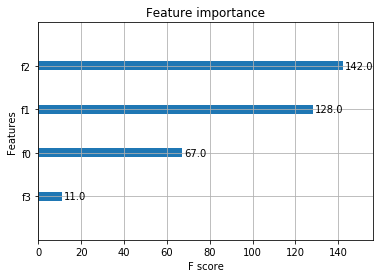

In [31]:
# feature importance
xgb.plot_importance(best_model)
plt.show()

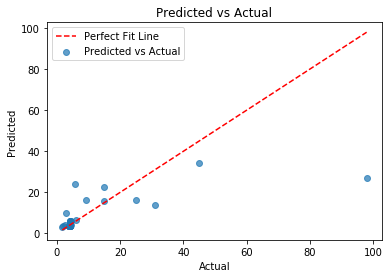

In [32]:
plt.scatter(y_test, y_pred, label="Predicted vs Actual", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit Line")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.legend()
plt.show()

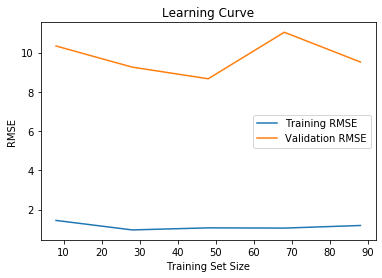

In [33]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train,
    scoring="neg_mean_squared_error", cv=3, n_jobs=-1
)

train_rmse = (-train_scores.mean(axis=1))**0.5
val_rmse = (-val_scores.mean(axis=1))**0.5

plt.plot(train_sizes, train_rmse, label='Training RMSE')
plt.plot(train_sizes, val_rmse, label='Validation RMSE')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.title("Learning Curve")
plt.show()

Overfitting is possible since the training RMSE is good but the validation metric is not.
- apply L1 or L2 regularization
- reduce max depth? Or just keep what grid search said

In [34]:
# compare to mean baseline
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_rmse = mean_squared_error(y_test, baseline_model.predict(X_test), squared=False)
print("Baseline RMSE:", baseline_rmse)


Baseline RMSE: 17.77203759249393


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best Score (RMSE): 9.617661402857077
Test RMSE: 12.396436460478764


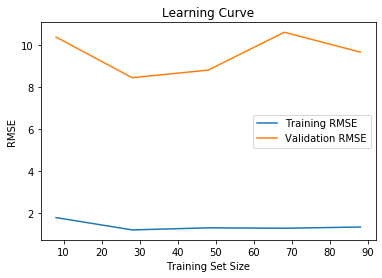

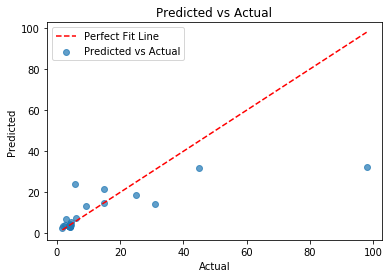

In [35]:
# boosted trees with grid search
# GRID SEARCH for hyperparameter tuning

# add 
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", use_label_encoder=False, reg_alpha = 1.0)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5], # 7
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3-fold cross-validation, limited due to memory constraints
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

# best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = grid_search.best_estimator_.predict(X_test)
test_predictions = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train,
    scoring="neg_mean_squared_error", cv=3, n_jobs=-1
)

train_rmse = (-train_scores.mean(axis=1))**0.5
val_rmse = (-val_scores.mean(axis=1))**0.5

plt.plot(train_sizes, train_rmse, label='Training RMSE')
plt.plot(train_sizes, val_rmse, label='Validation RMSE')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.title("Learning Curve")
plt.show()

plt.scatter(y_test, y_pred, label="Predicted vs Actual", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit Line")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.legend()
plt.show()

We see that we out-perform a mean baseline.

- L1 provides slight improvement over L2 or absence of both
- Performs well at predicting low concentrations but tapers off as actual concentrations grow, indicating that it may underestimate severity of amounts

In [36]:
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)


R² score: 0.5124082692723984
